<a href="https://colab.research.google.com/github/kookie14/Image-Processing-and-Robot-Vison/blob/main/th5_main_20020637.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bài tập
## Thực hiện bài toán phân loại với dữ liệu cho trước.
1. Sử dụng Kmeans Clustering để thực hiện Quantization các màu sắc cho bộ dữ
liệu trên (Có thể thay đổi từ 8-16-64-256 màu).
2. Trích xuất đặc trưng, sau đó sử dụng KNN hoặc SVM để phân loại.
3. So sánh kết quả với kết quả sử dụng H-histogram của HSV.

### Load thư viện

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from numpy import savetxt
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import classification_report

### Load file dữ liệu

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images = "/content/drive/MyDrive/Colab Notebooks/TH5/dataset/leedsbutterfly/images"
segment = "/content/drive/MyDrive/Colab Notebooks/TH5/dataset/leedsbutterfly/segmentations"
cropImage = "/content/drive/MyDrive/Colab Notebooks/TH5/cropImage"
feature = "/content/drive/MyDrive/Colab Notebooks/TH5/Feature"

### Tiền xử lý dữ liệu

* để tập trung vào màu của object thì ta sẽ kết hợp ảnh ban đầu với segment tương ứng của nó để xoá background xung quanh vật thể

In [ ]:
def removeBackground(img,seg):
    mask = seg[:,:,2]/255
    new_img = np.zeros((seg.shape))
    new_img[:,:,0] = mask*img[:,:,0]
    new_img[:,:,1] = mask*img[:,:,1]
    new_img[:,:,2] = mask*img[:,:,2]
    return new_img.astype(np.uint8)

* test thử hàm xoá nền

[[133   0 137 ...   0 140   0]
 [  0   0   0 ...   0   0   0]
 [134   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [133   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


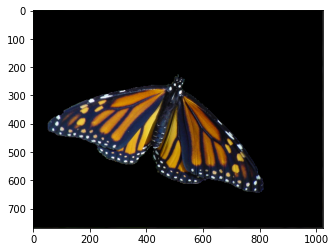

In [ ]:
img  = cv.imread("/content/drive/MyDrive/Colab Notebooks/TH5/dataset/leedsbutterfly/images/0010001.png")
segmet =cv.imread("/content/drive/MyDrive/Colab Notebooks/TH5/dataset/leedsbutterfly/segmentations/0010001_seg0.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = removeBackground(img, segmet)
plt.imshow(img)
print(img[0:100, 0: 100, 1])

* để tách được ảnh mình vật thể ra thì ta lấy hết các vùng ảnh màu trắng trong segmentation (có giá trị là 255)

In [ ]:
def deleteBackPoint(image):
  cols =[]
  rows = []
  for i in range(image.shape[0]):
    if 255 in image[i, :]:
      rows.append(i)
  for i in range(image.shape[1]):
    if 255 in image[:, i]: 
      cols.append(i)
  return rows, cols

* đọc song song ảnh với segment, để lấy được vùng ảnh của vật thể trong ảnh màu

In [ ]:
# for img, seg in zip(sorted(os.listdir(images)), sorted(os.listdir(segment))):
#   image  = cv.imread(images + "/"+ img)
#   segIm = cv.imread(segment + "/"+ seg,0)
#   rows, cols = deleteBackPoint(segIm)
#   cropIm = image[rows[0]: rows[-1], cols[0]: cols[-1], :]
#   cv.imwrite(cropImage + "/" + img, cropIm)



* so sánh ảnh đã cắt với ảnh chưa cắt

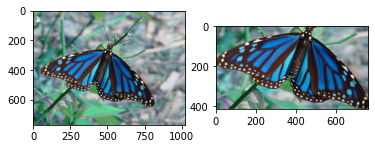

In [ ]:
img1  = cv.imread("/content/drive/MyDrive/Colab Notebooks/TH5/dataset/leedsbutterfly/images/0010001.png")
img2 = cv.imread("/content/drive/MyDrive/Colab Notebooks/TH5/cropImage/0010001.png")
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(img2)

## Histogram

* sử dụng ảnh đã crop để trích xuất đặc trưng của ảnh

In [ ]:
def get_Hchannel(img:np):
    hsvImage = cv.cvtColor(img.astype('uint8')*255, cv.COLOR_RGB2HSV)
    H_channel = hsvImage[:, :,0].reshape(-1)
    hist = np.bincount(H_channel, minlength= 256)
    return hist

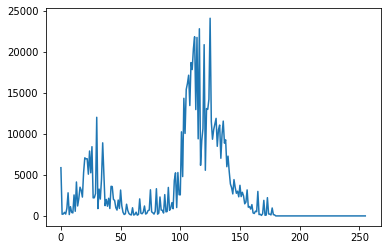

In [ ]:
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
x = get_Hchannel(img1)
plt.plot(x)
plt.show()

* Giảm chiều màu ảnh

In [ ]:
def recreateImage(codebook, labels,w,h):
  return codebook[labels].reshape(w,h, -1)

In [ ]:
def quantizationKMeans(img, n_colors):
    img = cv.imread(img)
    img =cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.array(img, dtype=np.float64) / 255
    # Load Image and transform to a 2D numpy array.
    w, h, d = original_shape = tuple(img.shape)
    assert d == 3
    image_array = np.reshape(img, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    return recreateImage(kmeans.cluster_centers_, labels, w, h)

In [ ]:
data  = []
labels = []
for image in os.listdir(cropImage):
    path_image = cropImage + "/" + image
    labels.append(image[:3])
    img = quantizationKMeans(path_image,16)
    featureH = get_Hchannel(img)
    data.append(featureH)


In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2)


In [ ]:
labels = dict.fromkeys(labels)

In [ ]:
model1 = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
model1.fit(X_train, Y_train)
labelPredict = model1.predict(X_test)
print(classification_report(Y_test, labelPredict, target_names=labels.keys()))

              precision    recall  f1-score   support

         001       0.08      0.25      0.12        12
         002       0.03      0.06      0.04        17
         003       0.11      0.07      0.08        15
         004       0.06      0.06      0.06        17
         005       0.00      0.00      0.00        19
         006       0.20      0.14      0.17        21
         007       0.33      0.33      0.33        18
         008       0.20      0.10      0.13        10
         009       0.18      0.09      0.12        23
         010       0.08      0.07      0.07        15

    accuracy                           0.11       167
   macro avg       0.13      0.12      0.11       167
weighted avg       0.13      0.11      0.11       167



In [ ]:
from sklearn.cluster import KMeans
def quantizationColorVector(img: np, n_cluster, k = 2):
    vector = img.reshape((-1, 3))
    model = KMeans(n_clusters = n_cluster)
    model.fit(vector)
    center = model.cluster_centers_
    id = model.predict(vector)
    argmax_id = np.argmax(np.bincount(id))
    sort_id = np.argsort(np.bincount(id))
    argmax_center = center[sort_id[n_cluster-k:]]  # lấy 2 cụm xuất hiện nhiều nhất
    if argmax_center[0,0] > argmax_center[1,0]:
        argmax_center[[0,1]] = argmax_center[[1,0]]
    return argmax_center.astype(np.uint8).reshape(-1)

## Sử dụng phương pháp trích xuất đặc trưng từ pixel của ảnh

In [ ]:
def getPixelData(img, mask):    
    rows = []
    cols = []
    data = []
    for i in range(mask.shape[0]):
        if 255 in mask[i,:]:
            for j in range(mask.shape[1]):
                if mask[i,j] == 255:
                    rows.append(i)
                    cols.append(j)
    for row, col in zip(rows, cols):
        data.append(img[row,col,:])
    return data


In [ ]:
for img_, seg in zip(sorted(os.listdir(images)), sorted(os.listdir(segment))):
  img = cv.imread(images + "/"+ img_)
  seg = cv.imread(segment + "/"+ seg,0)
  img= cv.cvtColor(img, cv.COLOR_BGR2RGB)
  featureD = getPixelData(img, seg)
  featureD = np.array(featureD)
  savetxt(feature + "/" + img_[:7]  + ".txt", featureD, delimiter = ",  ", fmt = "%d")

In [ ]:

k = 2
features = []
labels = []
for data_path in sorted(os.listdir(feature)):
    vector = loadtxt(feature + "/" + data_path, dtype = np.uint8, delimiter = ", ")
    center = quantizationColorVector(vector, 2, )
    features.append(center)
    labels.append((data_path[:3]))
features = np.array(features)
labels = np.array(labels)

In [ ]:
features.shape


(832, 6)

In [ ]:
labels.shape

(832,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 1)

In [ ]:
labels = dict.fromkeys(labels)

In [ ]:
model2 = KNeighborsClassifier(n_neighbors=5)
model2.fit(X_train, y_train)
labelPredict = model2.predict(X_test)
print(classification_report(y_test, labelPredict, target_names=labels.keys()))

              precision    recall  f1-score   support

         001       0.62      0.44      0.52        18
         002       0.43      0.43      0.43        14
         003       0.89      0.73      0.80        11
         004       0.46      0.63      0.53        19
         005       0.81      0.81      0.81        16
         006       0.65      0.79      0.71        14
         007       0.65      0.55      0.59        20
         008       1.00      0.75      0.86        12
         009       0.68      0.88      0.77        26
         010       0.25      0.18      0.21        17

    accuracy                           0.62       167
   macro avg       0.64      0.62      0.62       167
weighted avg       0.63      0.62      0.62       167



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
model3 = SVC(C = 10)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy:", accuracy)

SVM accuracy: 0.718562874251497
